In [ ]:
!pip install librosa soundfile matplotlib numpy torch torchaudio transformers datasets sox pydub

In [2]:
import os
import requests
import zipfile

os.makedirs("data", exist_ok=True)
os.makedirs("data/ravdess", exist_ok=True)
os.makedirs("data/clean_speech", exist_ok=True)   # for denoising later
os.makedirs("data/noise", exist_ok=True)

# RAVDESS emotional speech dataset
ravdess_url = "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip"

zip_path = "data/ravdess.zip"

if not os.path.exists(zip_path):
    print("Downloading RAVDESS dataset...")
    r = requests.get(ravdess_url)
    with open(zip_path, 'wb') as f:
        f.write(r.content)
    print("Downloaded RAVDESS.")

print("Extracting dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("data/ravdess")
print("Extraction completed.")

Downloaded RAVDESS.
Extracting dataset...
Extraction completed.


In [3]:
import os
import pandas as pd

ravdess_path = "data/ravdess"

emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

filepaths = []
emotions = []

for root, dirs, files in os.walk(ravdess_path):
    for file in files:
        if file.endswith(".wav"):
            full_path = os.path.join(root, file)

            parts = file.split("-")
            emotion_id = parts[2]

            if emotion_id in emotion_map:
                filepaths.append(full_path)
                emotions.append(emotion_map[emotion_id])

df = pd.DataFrame({
    "filepath": filepaths,
    "emotion": emotions
})

df.head(), df.shape

(                                         filepath  emotion
 0  data/ravdess/Actor_07/03-01-05-02-01-01-07.wav    angry
 1  data/ravdess/Actor_07/03-01-02-01-01-02-07.wav     calm
 2  data/ravdess/Actor_07/03-01-06-02-02-02-07.wav  fearful
 3  data/ravdess/Actor_07/03-01-03-02-01-01-07.wav    happy
 4  data/ravdess/Actor_07/03-01-03-01-01-02-07.wav    happy,
 (1440, 2))

In [4]:
import librosa
import numpy as np
from tqdm import tqdm

def extract_mel(filepath, sr=16000, n_mels=64, duration=3):

    audio, _ = librosa.load(filepath, sr=sr)

    target_len = sr * duration
    if len(audio) < target_len:
        audio = np.pad(audio, (0, target_len - len(audio)))
    else:
        audio = audio[:target_len]

    mel = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_mels=n_mels
    )

    mel_db = librosa.power_to_db(mel, ref=np.max)

    return mel_db.astype(np.float32)

mel_features = []
labels = []

print("Extracting mel spectrograms...")

for i, row in tqdm(df.iterrows(), total=len(df)):
    mel = extract_mel(row["filepath"])
    mel_features.append(mel)
    labels.append(row["emotion"])

X = np.array(mel_features)  # shape = (N, 64, Time)
y = np.array(labels)

X.shape, y.shape


Extracting mel spectrograms...


100%|██████████| 1440/1440 [00:22<00:00, 64.56it/s] 


((1440, 64, 94), (1440,))

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # y was from Block 4

num_classes = len(label_encoder.classes_)
print("Emotion classes:", label_encoder.classes_)
print("num_classes:", num_classes)

X_expanded = np.expand_dims(X, axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_expanded,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

Emotion classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
num_classes: 8


((1152, 1, 64, 94), (288, 1, 64, 94), (1152,), (288,))

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)   # mel spectrogram
        self.y = torch.tensor(y, dtype=torch.long)      # emotion label

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = EmotionDataset(X_train, y_train)
val_dataset = EmotionDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

len(train_loader), len(val_loader)

(72, 18)

In [10]:
import torch
import torch.nn as nn

class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),   # reduces time + freq dims

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )

        self.gru = nn.GRU(
            input_size=64,
            hidden_size=128,
            batch_first=True,
            bidirectional=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, 128),   # 128*2 because bidirectional GRU
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
      # x: (batch, 1, 64, T)
      x = self.cnn(x)  # -> (batch, 64, newF, newT)

      # x: (B, 64, f, t)
      b, c, f, t = x.size()

      # Reduce frequency axis → (B, 64, t)
      x = torch.mean(x, dim=2)

      # Reorder → (B, t, 64)
      x = x.permute(0, 2, 1)

      # GRU → (B, t, 256)
      gru_out, _ = self.gru(x)

      # Last time step → (B, 256)
      last_step = gru_out[:, -1, :]

      # Classifier
      out = self.classifier(last_step)
      return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN(num_classes=num_classes).to(device)

model

EmotionCNN(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (gru): GRU(64, 128, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, b

In [11]:
import torch.optim as optim
import torch.nn.functional as F

epochs = 15
learning_rate = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)

        loss = criterion(outputs, y_batch)
        loss.perform = loss.item()

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    return total_loss / total, correct / total


def validate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    return total_loss / total, correct / total


train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("Starting training...\n")

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_acc = validate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f}")


Starting training...

Epoch 1/15 | Train Loss: 1.9354 | Train Acc: 0.234 | Val Loss: 1.8164 | Val Acc: 0.285
Epoch 2/15 | Train Loss: 1.7305 | Train Acc: 0.337 | Val Loss: 1.7761 | Val Acc: 0.278
Epoch 3/15 | Train Loss: 1.6575 | Train Acc: 0.352 | Val Loss: 1.6263 | Val Acc: 0.410
Epoch 4/15 | Train Loss: 1.5433 | Train Acc: 0.409 | Val Loss: 1.5971 | Val Acc: 0.378
Epoch 5/15 | Train Loss: 1.4458 | Train Acc: 0.438 | Val Loss: 1.6648 | Val Acc: 0.306
Epoch 6/15 | Train Loss: 1.3958 | Train Acc: 0.466 | Val Loss: 1.5799 | Val Acc: 0.434
Epoch 7/15 | Train Loss: 1.2981 | Train Acc: 0.522 | Val Loss: 1.4415 | Val Acc: 0.431
Epoch 8/15 | Train Loss: 1.2637 | Train Acc: 0.522 | Val Loss: 1.5895 | Val Acc: 0.399
Epoch 9/15 | Train Loss: 1.1945 | Train Acc: 0.541 | Val Loss: 2.0723 | Val Acc: 0.302
Epoch 10/15 | Train Loss: 1.1445 | Train Acc: 0.564 | Val Loss: 2.2201 | Val Acc: 0.344
Epoch 11/15 | Train Loss: 1.1102 | Train Acc: 0.583 | Val Loss: 1.6454 | Val Acc: 0.410
Epoch 12/15 | Train

In [12]:
import torch
import librosa
import numpy as np


model_path = "emotion_cnn_model.pth"
torch.save(model.state_dict(), model_path)
print("Model saved at:", model_path)


def predict_emotion(audio_path, model, label_encoder, sr=16000, duration=3):
    # Load audio
    audio, _ = librosa.load(audio_path, sr=sr)

    # Pad/crop to fixed length
    target_len = sr * duration
    if len(audio) < target_len:
        audio = np.pad(audio, (0, target_len - len(audio)))
    else:
        audio = audio[:target_len]

    # Mel spectrogram
    mel = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=64
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Shape: (1, 1, 64, T)
    mel_tensor = torch.tensor(mel_db, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(mel_tensor)
        pred_class = torch.argmax(logits, dim=1).item()

    emotion = label_encoder.inverse_transform([pred_class])[0]
    return emotion


loaded_model = EmotionCNN(num_classes=num_classes).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

print("Model loaded and ready for inference!")

Model saved at: emotion_cnn_model.pth
Model loaded and ready for inference!


In [13]:
test_path = df["filepath"].iloc[0]
print("Testing on:", test_path)

emotion = predict_emotion(test_path, loaded_model, label_encoder)
print("Predicted Emotion:", emotion)

Testing on: data/ravdess/Actor_07/03-01-05-02-01-01-07.wav
Predicted Emotion: angry


In [14]:
print("Final Training Accuracy:", train_accs[-1])
print("Final Validation Accuracy:", val_accs[-1])

Final Training Accuracy: 0.6744791666666666
Final Validation Accuracy: 0.5034722222222222


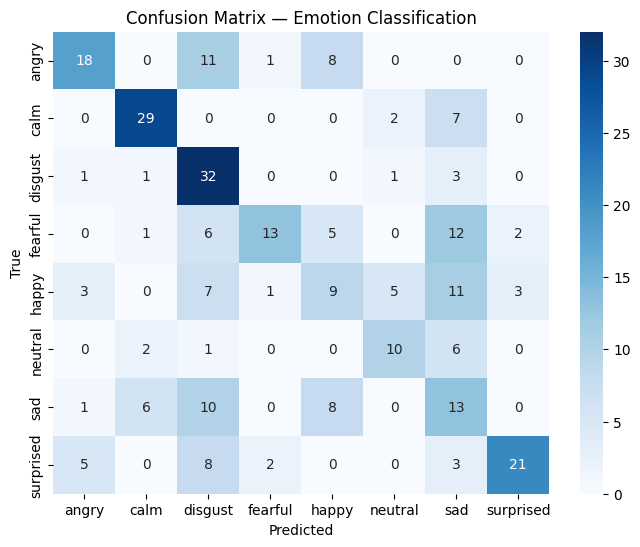

In [17]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Collect predictions on validation set
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)

        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_true.extend(y_batch.numpy())

cm = confusion_matrix(all_true, all_preds)
classes = label_encoder.classes_

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=classes,
    yticklabels=classes,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Emotion Classification")
plt.show()